In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import collections as clt
import networkx as nx
import pickle
import itertools
from joblib import Parallel, delayed
import math
from community import best_partition, modularity

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [3]:
df = pd.read_csv('reviews_full_v8.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment,Band_Genre,Combined_Genre,Key Features
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,power metal,I've been trying for months to come up with an...,0.5494,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...


In [4]:
all_features = pickle.load(open('opinionsv2.p','rb')) #sorted dictionary of phrases + frequency
print(len(all_features))

2189617


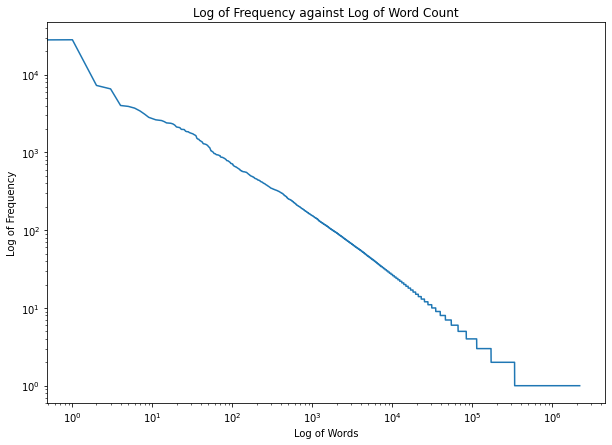

In [5]:
plt.title('Log of Frequency against Log of Word Count')
plt.ylabel('Log of Frequency')
plt.xlabel('Log of Words')
plt.loglog([1]+list(all_features.values()))
plt.show()

In [6]:
list(all_features.values())[:10]

[28110, 7272, 6564, 4015, 3909, 3712, 3414, 3104, 2827, 2720]

In [7]:
genre_group = pickle.load(open('genre_group.p','rb'))

In [8]:
t1 = time.time()
B = nx.Graph()
featureset = set()
album_to_genre = {}
all_genres = []

def isNaN(x):
    return x != x

for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Key Features']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Key Features'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    if 'Non-metal' in genres:
        genres.remove('Non-metal')
    if 'Others' in genres:
        genres.remove('Others')
    all_genres += genres
    if album in album_to_genre:
        album_to_genre[album] = album_to_genre[album].union(set(genres))
    else:
        album_to_genre[album] = set(genres)
    for feature in features:
        if all_features[feature] >= 100 and 'metal' not in feature: #threshold, because graph starts to split when frequency < 10
            featureset.add(feature)
            if not B.has_edge(album,feature):
                B.add_edge(album, feature)

0 0.07962775230407715
10000 1.670518398284912
20000 3.228348731994629
30000 5.159209489822388
40000 6.5318074226379395
50000 8.084200620651245
60000 9.546252250671387
70000 10.920130252838135
80000 12.925079822540283
90000 14.872097969055176


In [9]:
B.number_of_nodes(), B.number_of_edges(), len(featureset)

(32989, 352130, 1640)

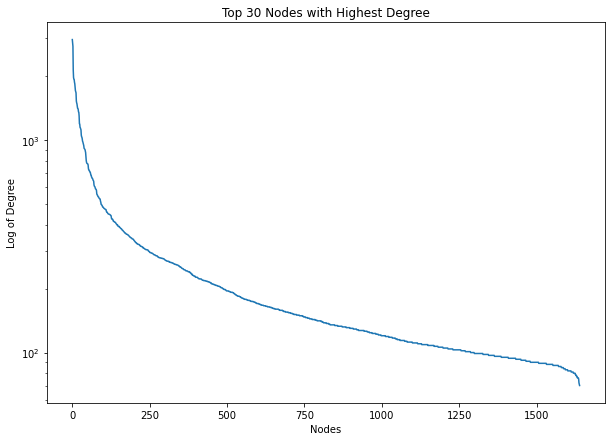

In [10]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[feature] for feature in featureset], reverse = True)
plt.semilogy(tmp)
plt.show()

In [11]:
tmp = sorted([(B.degree[feature],feature) for feature in featureset], reverse = True)
tmp[:10]

[(2965, 'clean vocals'),
 (2845, 'originally written'),
 (2757, 'little bit'),
 (2131, 'written http'),
 (1965, 'sorry review'),
 (1931, 'old school'),
 (1925, 'entire album'),
 (1868, 'double bass'),
 (1837, 'good album'),
 (1766, 'vocal performance')]

In [12]:
rem_nodes = [node for f,node in tmp[:250]]
B.remove_nodes_from(rem_nodes)
print(len(featureset))
featureset = featureset.difference(set(rem_nodes))
print(len(featureset))

1640
1390


In [13]:
G = nx.Graph()
for feature1 in featureset:
    for album in B.adj[feature1]:
        for feature2 in B.adj[album]:
            if feature2 >= feature1:
                continue
            if G.has_edge(feature1,feature2):
                G[feature1][feature2]['weight'] += 1
                G[feature1][feature2]['albums'].add(album)
            else:
                G.add_edge(feature1, feature2, weight = 1, albums = {album})
G.number_of_nodes(), G.number_of_edges()

(1390, 762810)

In [14]:
G2 = G.copy()

In [15]:
K = G.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
G = nx.Graph(Core)
G.number_of_nodes(), G.number_of_edges()

(1168, 586801)

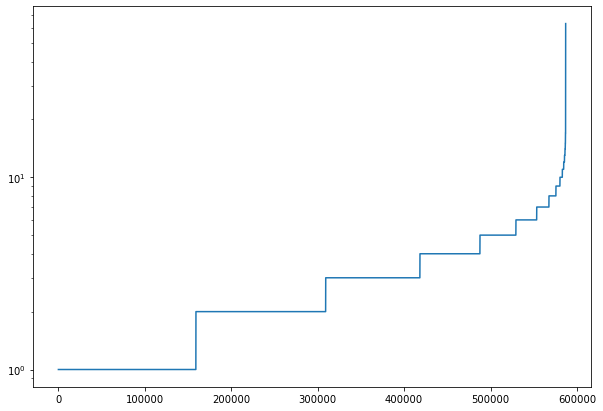

In [16]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [23]:
G3 = G.copy()
for u,v in G3.edges():
    if G3[u][v]['weight'] < 10:
        G.remove_edge(u,v)
print(len(list(nx.isolates(G))))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes(), G.number_of_edges()

410


(758, 6668)

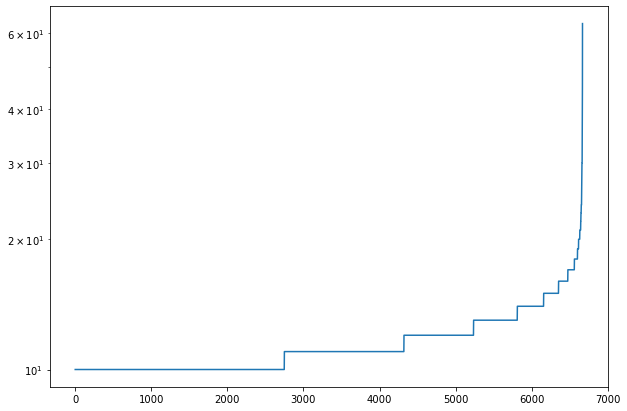

In [46]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [24]:
partitions = best_partition(G,randomize = True, weight = 'weight')
print(max(partitions.values()))
partitions_by_cluster = {i:[] for i in range(max(partitions.values())+1)}
for node in partitions:
    partitions_by_cluster[partitions[node]].append(node)
clusters = [G.subgraph(partitions_by_cluster[i]) for i in range(max(partitions.values())+1)]

9


In [25]:
modularity(partitions, G, weight = 'weight') #without weight threshold, modularity = 0.0275

0.18189701531297817

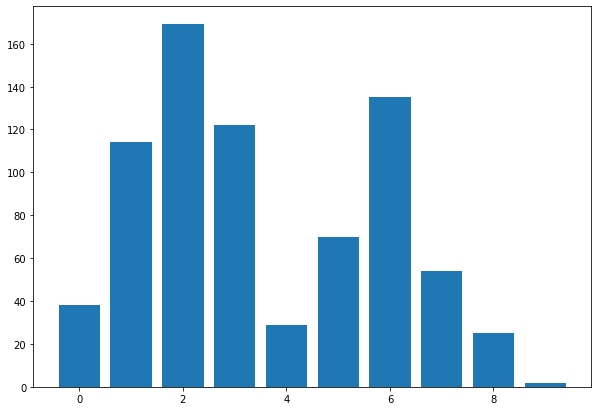

In [26]:
tmp = clt.Counter(list(partitions.values()))
plt.bar(tmp.keys(),tmp.values())
plt.show()

In [64]:
def get_kcore(Graph):
    K = Graph.copy()
    K.remove_edges_from(nx.selfloop_edges(K))
    K = nx.k_core(K)
    sortbylen = lambda cc : len(cc)
    return K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])

In [76]:
condensed_genres = [genre_group[genre] for genre in all_genres if genre in genre_group]
genre_freq = clt.Counter(condensed_genres)
#genre_freq = clt.Counter(all_genres)

def printCluster(ind, use_kcore = True):
    Graph = clusters[ind]
    if use_kcore:
        Graph = get_kcore(Graph)
    genre_list = []
    albums = set()
    for u,v in Graph.edges():
        albums = albums.union(G[u][v]['albums'])
    for album in albums:
        genre_list += [genre_group[genre] for genre in album_to_genre[album] if genre in genre_group]
    tmp = clt.Counter(genre_list)
    '''
    for key in tmp:
        #print(key,tmp[key], genre_freq[key], len(genre_list), len(G[u][v]['albums']))
        tmp[key] /= genre_freq[key] #percentage
        tmp[key] = round(tmp[key],2)
    '''
    tmp = {k: v for k, v in sorted(tmp.items(), key=lambda item: item[1], reverse = True)}
    print(tmp)
    print()
    print(clusters[ind].nodes())
    

In [84]:
printCluster(3)

{'Black metal': 97, 'Progressive metal': 85, 'Death metal': 75, 'Power metal': 72, 'Heavy metal': 67, 'Thrash metal': 59, 'Non-metal': 48, 'Doom metal': 44, 'Folk metal': 34, 'Symphonic metal': 25, 'Avantgarde metal': 23, 'Gothic metal': 18, 'Metalcore': 10, 'Viking metal': 9, 'Stoner metal': 8, 'Others': 7, 'Industrial metal': 7, 'Sludge metal': 6, 'Deathcore': 4, 'Grindcore': 4, 'Groove metal': 2}

['beautiful melodies', 'truly unique', 'great opener', 'musical elements', 'acoustic parts', 'personal favourite', 'spoken vocals', 'minute mark', 'divided parts', 'different genres', 'main melody', 'album feel', 'vocal sections', 'fantastic job', 'vocal harmonies', 'hard describe', 'instrumental songs', 'acoustic passage', 'catchy choruses', 'hard hear', 'middle album', 'thought band', 'acoustic interludes', 'bad track', 'strong album', 'released band', 'instrumental tracks', 'long good', 'vocal melody', 'clear band', 'spoken parts', 'final tracks', 'fourth track', 'melodic guitars', 'oth

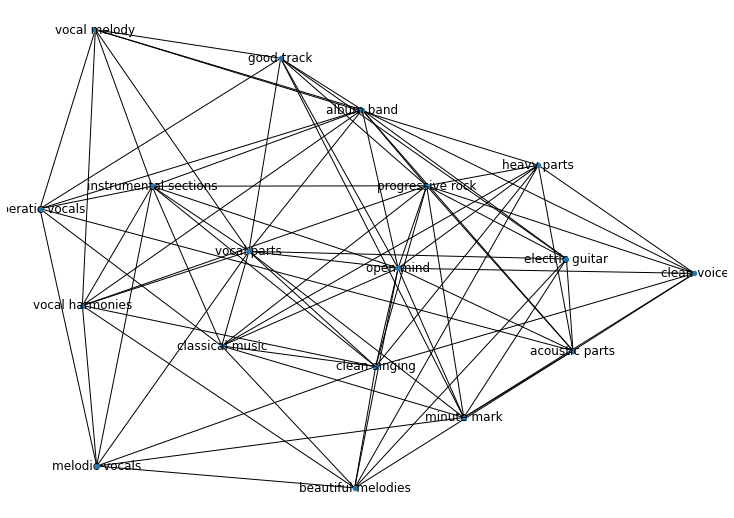

In [85]:
nx.draw(get_kcore(clusters[3]), node_size = 20, with_labels = True)

## Results from testing
After applying k-core again to cluster, we seem to get more moelodic traits and less noise. In addition, certain genres also pop out as main genres more often instead of being dominated by black and death metal